# 2. Model Building and Evaluation

### 0. Imports

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import cv2 as cv
from utils import *
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost

/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Load in Processed Images

In [2]:
cwd = os.getcwd()
data_path = os.path.join(cwd,'standardized_data/Training')

X = []
y = []

for label in os.listdir(data_path):
    for image in os.listdir(os.path.join(data_path,label)):
        image_path = os.path.join(data_path,label,image)
        load_image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        # flatten_image = load_image.flatten()
        X.append(load_image)
        y.append(label)


# Convert to Numpy Array
X = np.array(X)
y = np.array(y)
le = LabelEncoder()
le.fit(y) 
y = le.transform(y)

print(X.shape)
print(y.shape)

print(X[0])
print(y[0])

(5712, 512, 512)
(5712,)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
3


### 2. Base Model (most common class classifier)

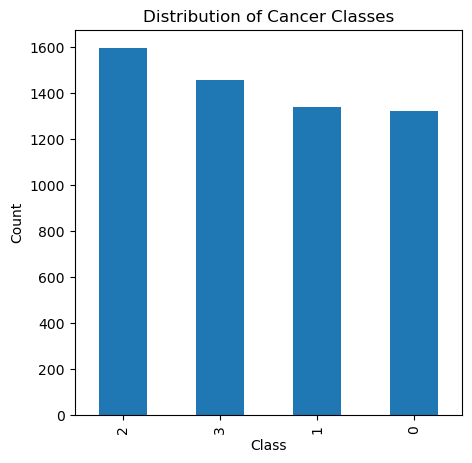

['glioma' 'meningioma' 'notumor' 'pituitary']


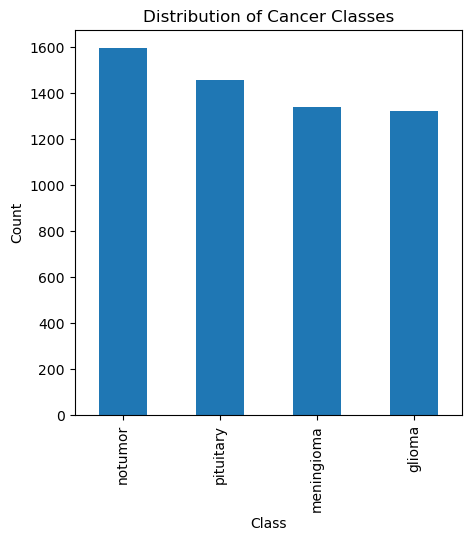

Most Common Label: 2
(5712,)
(5712,)


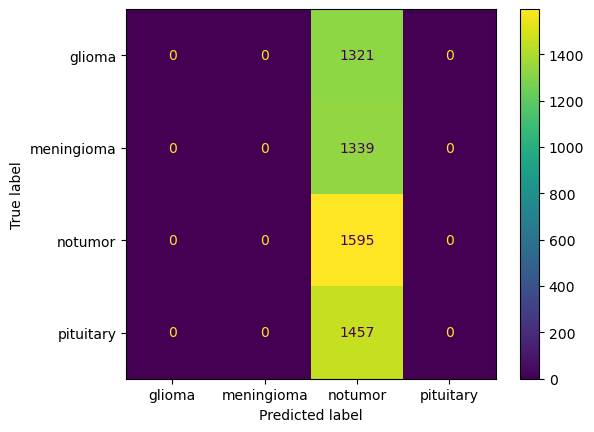

================== TRAINING METRICS ===================
Accuracy Score: 0.27923669467787116
Macro Precision: 0.06980917366946779
Macro Recall: 0.25
Macro F1: 0.10914191870808813
Micro Precision: 0.27923669467787116
Micro Recall: 0.27923669467787116
Micro F1: 0.27923669467787116


/Users/richardyan/miniforge3/envs/datasci281/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
plt.figure(figsize=(5,5))
y_train_series = pd.Series(y)
y_train_series.value_counts().plot(kind='bar')
plt.title('Distribution of Cancer Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()
print(le.classes_)
y_transformed = le.inverse_transform(y)

plt.figure(figsize=(5,5))
y_train_series = pd.Series(y_transformed)
y_train_series.value_counts().plot(kind='bar')
plt.title('Distribution of Cancer Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


# Generate Model Statistics
most_common_label = stats.mode(y)[0]
print("Most Common Label: " + str(most_common_label))
y_predict = np.ones((y.shape)) * most_common_label
print(y_predict.shape)
print(y.shape)

# Generate Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = le.classes_)
cm_display.plot()
plt.show()

accuracy_score = metrics.accuracy_score(y, y_predict)
macro_precision = metrics.precision_score(y,y_predict,average ='macro')
macro_recall = metrics.recall_score(y,y_predict,average='macro')
macro_f1 = metrics.f1_score(y,y_predict,average='macro')
micro_precision = metrics.precision_score(y,y_predict,average='micro')
micro_recall = metrics.recall_score(y,y_predict,average='micro')
micro_f1 = metrics.f1_score(y,y_predict,average='micro')

print("================== TRAINING METRICS ===================")
print("Accuracy Score: " + str(accuracy_score))
print("Macro Precision: " + str(macro_precision))
print("Macro Recall: " + str(macro_recall))
print("Macro F1: " + str(macro_f1))
print("Micro Precision: " + str(micro_precision))
print("Micro Recall: " + str(micro_recall))
print("Micro F1: " + str(micro_f1))

### 3. Extract Features (Canny Edges, Difference of Gaussians, Complex Feature)
- Commented out as feature generation takes a long time (>1 hour). We saved the features into numpy files as well as csv to load in for training later.

In [4]:
# ### TBD
# X_dog_features = get_features(X, feat_name='blob_dog')
# X_doh_features = get_features(X, feat_name='blob_doh')
# X_canny_features = get_features(X, feat_name='canny')
# pca = PCA(n_components=1000, svd_solver="randomized", whiten=True).fit(X_canny_features)
# X_pca_canny_features = pca.transform(X_canny_features)
# # X_complex_features = get_features(X, feat_name='complex')

# np.save('X_train_dog_features.npy', X_dog_features)
# np.save('X_train_doh_features.npy', X_doh_features)
# np.save('X_train_pca_canny_features.npy', X_pca_canny_features)
# # np.save('X_train_complex_features.npy', X_complex_features)
# np.save('Y_train.npy',y)
# y_raw_train = le.inverse_transform(y)
# np.save('Y_raw_train.npy',y_raw_train)
# print(y.shape)
# print(y_raw_train.shape)

### 3a. Load Features

In [5]:
aligned_train_features = pd.read_csv('extracted_features/aligned_training_features.csv')
aligned_train_features, dims, enc = clean_df(
    df=aligned_train_features,
    label_col="target",
    feat_cols=["feat_canny", "feat_vec", "feat_dog", "feat_doh"]
)

parsed_aligned_train_features  = parse_aligned_features(aligned_train_features, ['feat_canny', 'feat_vec', 'feat_dog', 'feat_doh'])

# Feature Loading
X_dog_features = parsed_aligned_train_features['feat_dog']
X_doh_features = parsed_aligned_train_features['feat_doh']
X_complex_features = parsed_aligned_train_features['feat_vec']
X_train_pca_canny_features = np.load('extracted_features/X_train_pca_canny_features.npy')

# Label Loading
y_train = parsed_aligned_train_features['target']


### 3a. PCA/tSNE

- See [blob_detection.ipynb](./blob_detection.ipynb) for DoG and DoH PCA and tSNE Plots
- See [canny_edges.ipynb](./canny_edges.ipynb) for Canny edges PCA and tSNE Plots

In [6]:
# x = plot_PCA([X_dog_features, X_doh_features, X_train_pca_canny_features, X_complex_features], n_components=[min(X_dog_features.shape), min(X_doh_features.shape), 1000, min(X_complex_features.shape)])


### 4. Shuffle Data

In [7]:
np.random.seed(281)

# Create a list of indexes that is the length of the number of training examples
indices = [i for i in range(0,X.shape[0])]
shuffle_indices = np.random.permutation(indices)

X_dog_features = X_dog_features[shuffle_indices]
X_doh_features = X_doh_features[shuffle_indices]
X_canny_features = X_train_pca_canny_features[shuffle_indices]
X_complex_features = X_complex_features[shuffle_indices]

y_train = y_train[shuffle_indices]

In [8]:
print(X_dog_features.shape)
print(X_dog_features.shape)
print(X_canny_features.shape)
print(X_complex_features.shape)

(5712, 14)
(5712, 14)
(5712, 1000)
(5712, 768)


### 5. Model Training

In [9]:
# model_types = ['logistic','svm','rf','lda','qda']

# features = {'dog':X_dog_features,
#             'doh':X_doh_features,
#             'canny':X_canny_features,
#             'complex': X_complex_features,
#             'dog_doh': np.concatenate((X_dog_features, X_doh_features), axis=1),
#             'doh_complex': np.concatenate((X_doh_features, X_complex_features), axis=1),
#             'dog_complex': np.concatenate((X_dog_features, X_complex_features), axis=1),
#             'dog_doh_complex': np.concatenate((X_dog_features, X_doh_features, X_complex_features), axis=1)
#             }

# all_results = pd.DataFrame(columns = ['feature', 'model_type', 'accuracy_score', 'macro_precision', 'macro_recall', 'macro_f1', 
#                                       'micro_precision', 'micro_recall', 'micro_f1', 'training_time'])
# model_store = {}

# for model_type in model_types:
#     for feature in features.keys():
#         model, results = train_model(features[feature], y_train, classes=le.classes_, model_type=model_type, feature=feature)
#         all_results.loc[len(all_results)] = results
#         model_store[str(model_type) + "_" + str(feature)] = model
#     save_models(model_store)

# print(all_results)

# all_results.to_csv('results/training_results.csv')

### 6. Load Models

In [10]:
model_types = ['logistic','svm','rf','lda','qda']

features = {'dog':X_dog_features,
            'doh':X_doh_features,
            'canny':X_canny_features,
            'complex': X_complex_features,
            'dog_doh': np.concatenate((X_dog_features, X_doh_features), axis=1),
            'doh_complex': np.concatenate((X_doh_features, X_complex_features), axis=1),
            'dog_complex': np.concatenate((X_dog_features, X_complex_features), axis=1),
            'dog_doh_complex': np.concatenate((X_dog_features, X_doh_features, X_complex_features), axis=1)
            }

loaded_models = {}

for model_type in model_types:
    for feature in features.keys():
        feature_model = str(model_type) + "_" + str(feature)
        try:
            loaded_models[feature_model] = joblib.load("models//" + str(feature_model) + ".joblib")
        except:
            print("Could not load " + str(feature_model))



In [11]:
print(loaded_models.keys())

dict_keys(['logistic_dog', 'logistic_doh', 'logistic_canny', 'logistic_complex', 'logistic_dog_doh', 'logistic_doh_complex', 'logistic_dog_complex', 'logistic_dog_doh_complex', 'svm_dog', 'svm_doh', 'svm_canny', 'svm_complex', 'svm_dog_doh', 'svm_doh_complex', 'svm_dog_complex', 'svm_dog_doh_complex', 'rf_dog', 'rf_doh', 'rf_canny', 'rf_complex', 'rf_dog_doh', 'rf_doh_complex', 'rf_dog_complex', 'rf_dog_doh_complex', 'lda_dog', 'lda_doh', 'lda_canny', 'lda_complex', 'lda_dog_doh', 'lda_doh_complex', 'lda_dog_complex', 'lda_dog_doh_complex', 'qda_dog', 'qda_doh', 'qda_canny', 'qda_complex', 'qda_dog_doh', 'qda_doh_complex', 'qda_dog_complex', 'qda_dog_doh_complex'])


### 7. Ensemble Method Training

================== TRAINING METRICS ===================
Accuracy Score: 0.9998249299719888
Macro Precision: 0.9998134328358209
Macro Recall: 0.9998107494322483
Macro F1: 0.9998120204843963
Micro Precision: 0.9998249299719888
Micro Recall: 0.9998249299719888
Micro F1: 0.9998249299719888


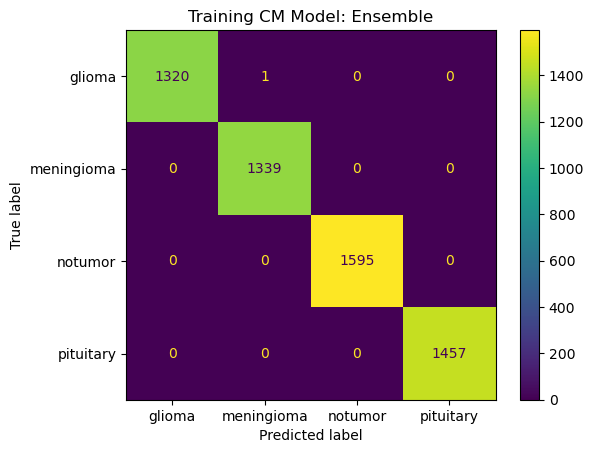

In [14]:
ensemble = FeatureVectorEnsemble(
    models=[loaded_models['logistic_canny'], loaded_models['svm_canny'], loaded_models['logistic_complex']],
    feature_sets=[X_canny_features, X_canny_features, X_complex_features],
    use_proba=True
)


y_ensemble_train_pred = []

for image in range(X_canny_features.shape[0]):
    prediction = ensemble.predict(image)
    y_ensemble_train_pred.append(prediction)

y_ensemble_train_pred = np.array(y_ensemble_train_pred)
accuracy_score = metrics.accuracy_score(y_train, y_ensemble_train_pred)
macro_precision = metrics.precision_score(y_train, y_ensemble_train_pred,average ='macro')
macro_recall = metrics.recall_score(y_train, y_ensemble_train_pred,average='macro')
macro_f1 = metrics.f1_score(y_train, y_ensemble_train_pred,average='macro')
micro_precision = metrics.precision_score(y_train, y_ensemble_train_pred,average='micro')
micro_recall = metrics.recall_score(y_train, y_ensemble_train_pred,average='micro')
micro_f1 = metrics.f1_score(y_train, y_ensemble_train_pred,average='micro')
# Generate Confusion Matrix for Logistic Regression
confusion_matrix = metrics.confusion_matrix(y_train, y_ensemble_train_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = le.classes_)
cm_display.plot()
plt.title('Training CM Model: Ensemble')

print("================== TRAINING METRICS ===================")
print("Accuracy Score: " + str(accuracy_score))
print("Macro Precision: " + str(macro_precision))
print("Macro Recall: " + str(macro_recall))
print("Macro F1: " + str(macro_f1))
print("Micro Precision: " + str(micro_precision))
print("Micro Recall: " + str(micro_recall))
print("Micro F1: " + str(micro_f1))

### 8. Final Test Evaluation

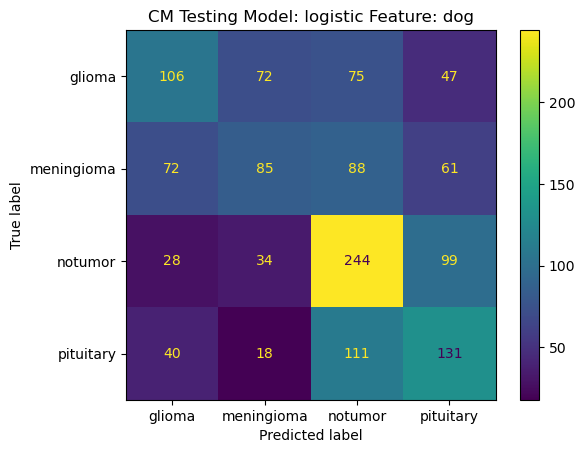

(1311, 4)


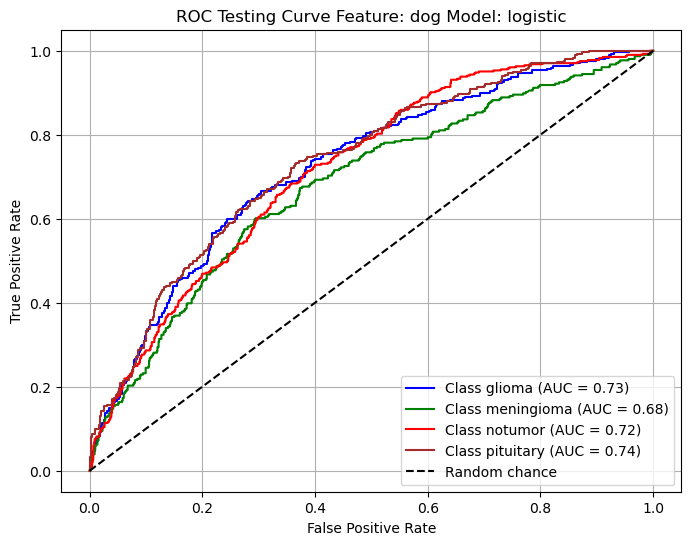

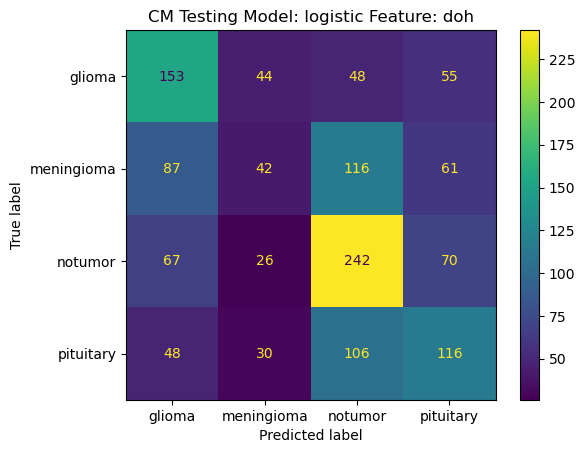

(1311, 4)


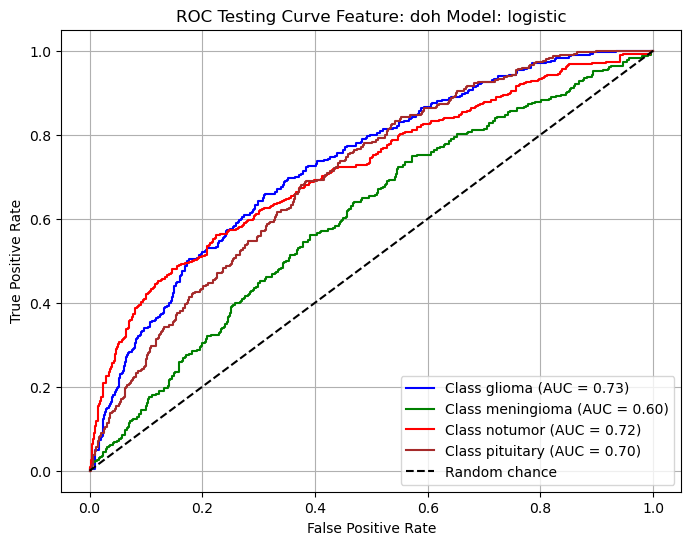

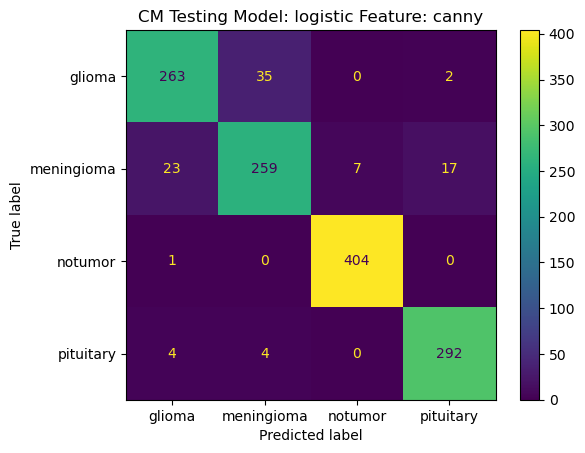

(1311, 4)


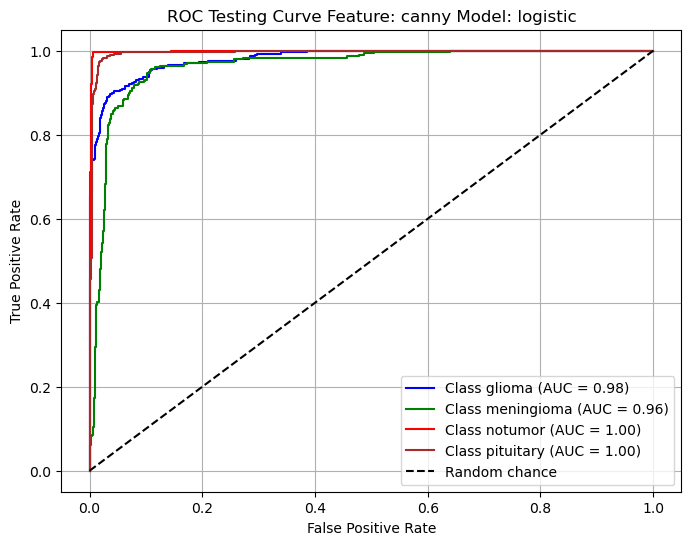

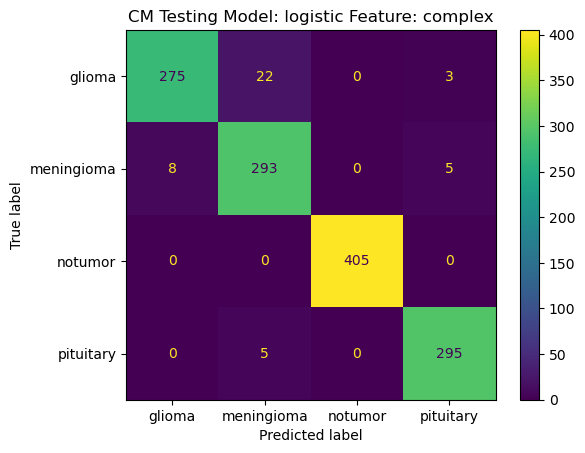

(1311, 4)


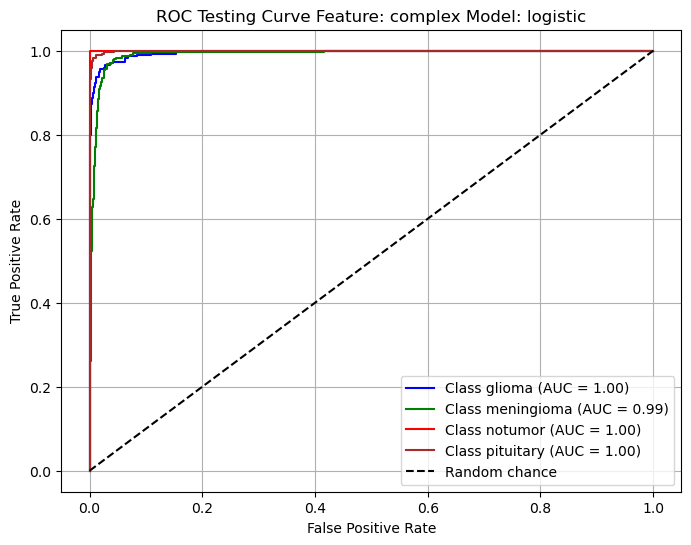

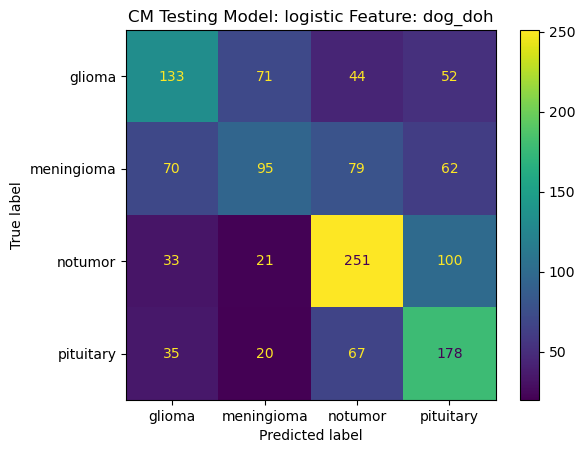

(1311, 4)


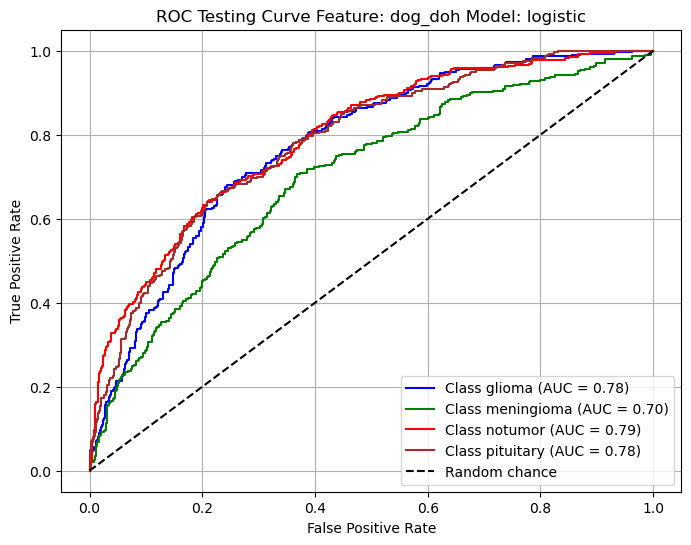

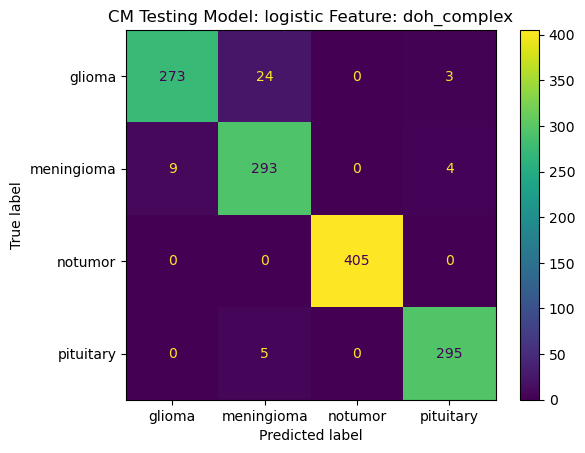

(1311, 4)


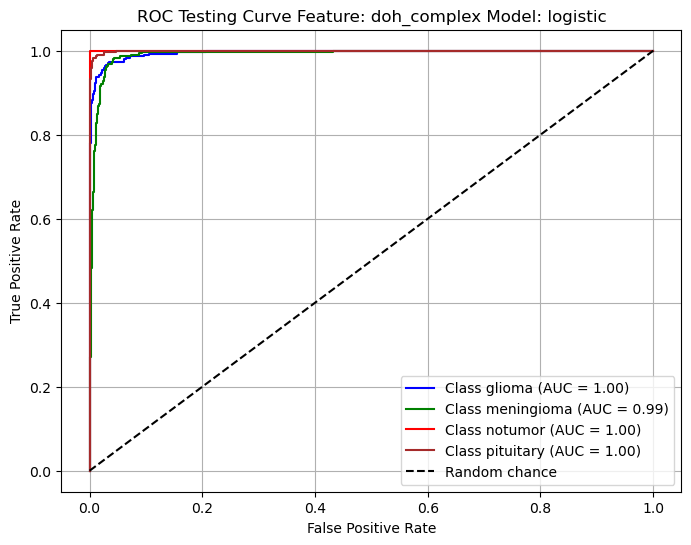

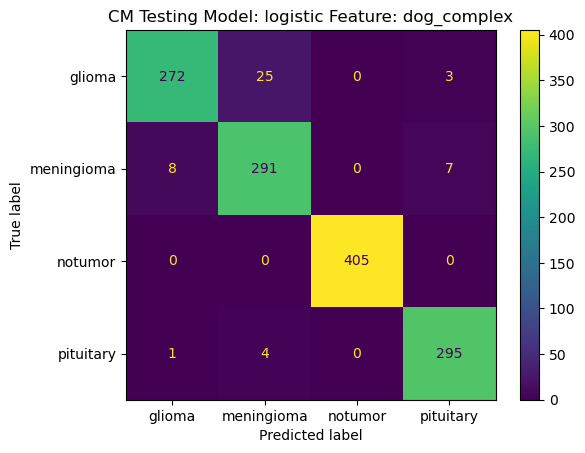

(1311, 4)


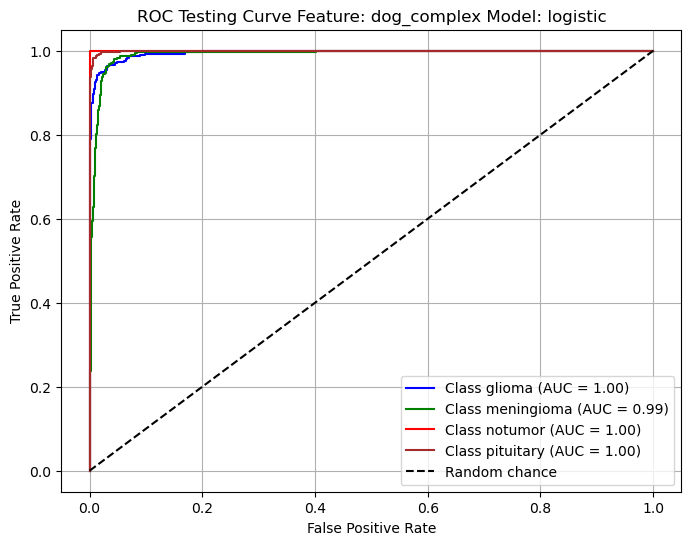

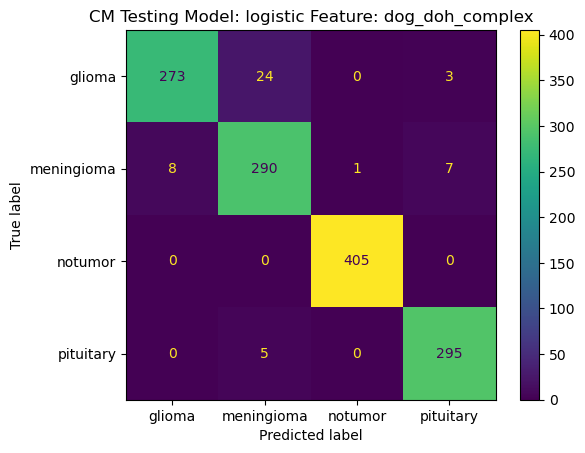

(1311, 4)


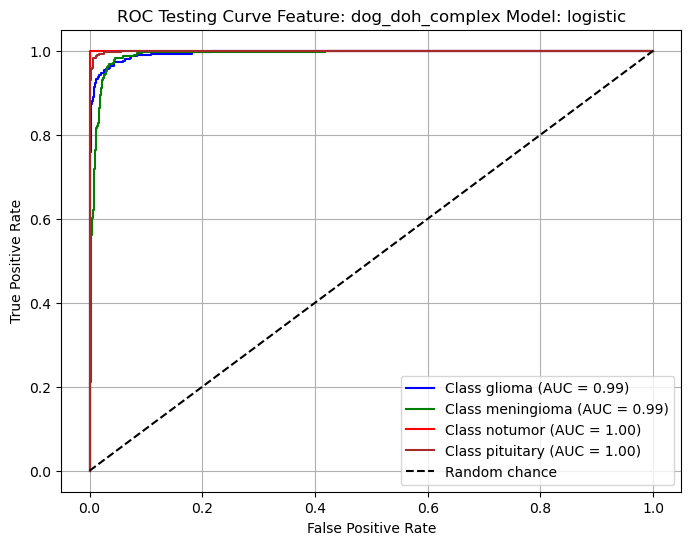

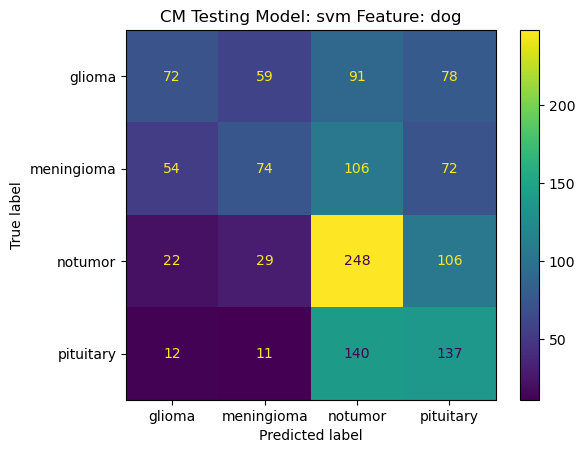

(1311, 4)


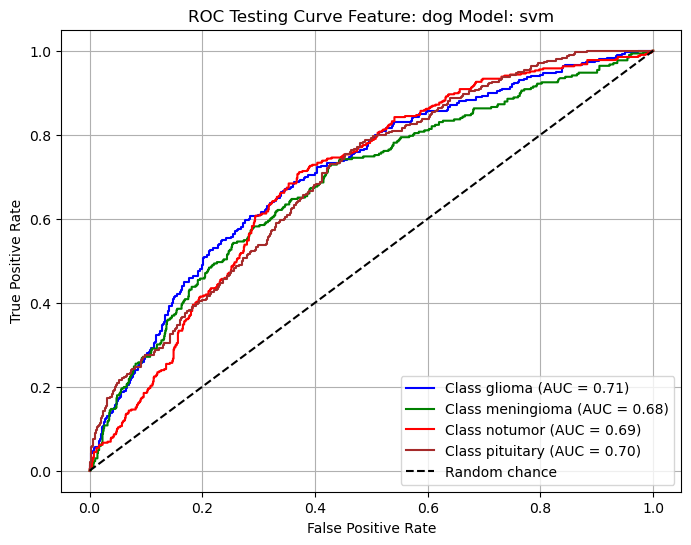

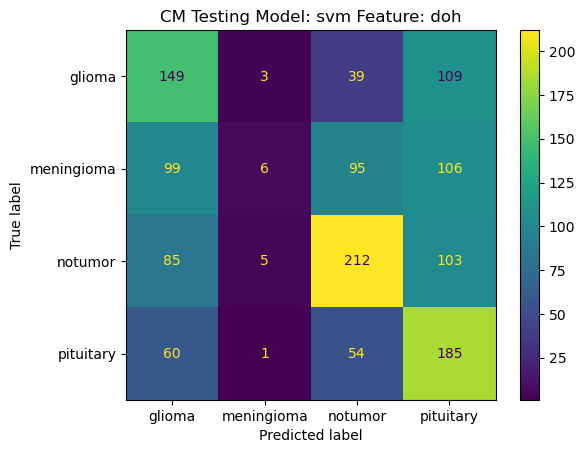

(1311, 4)


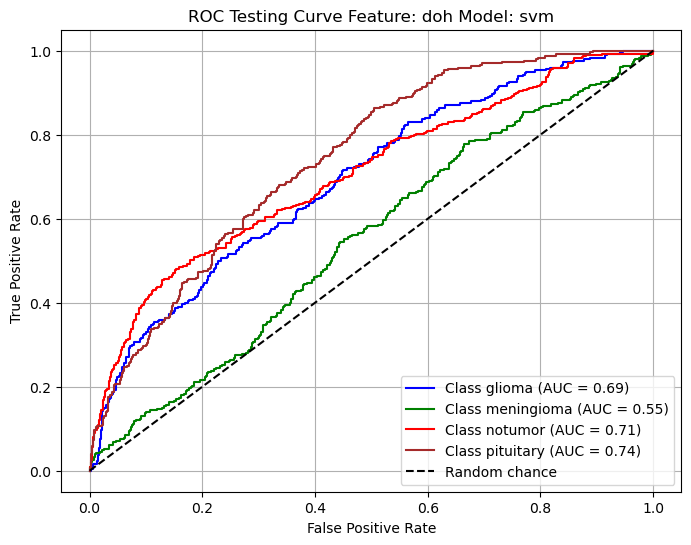

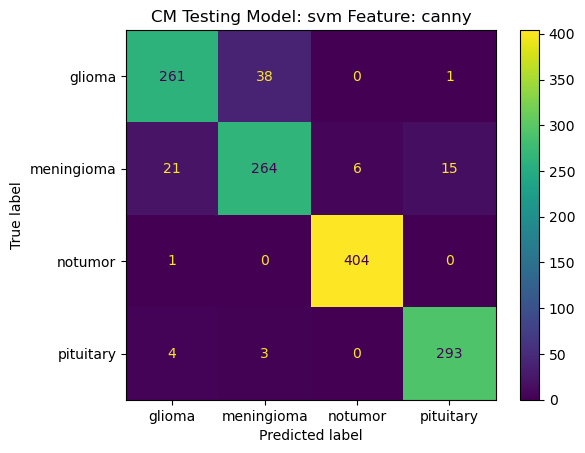

(1311, 4)


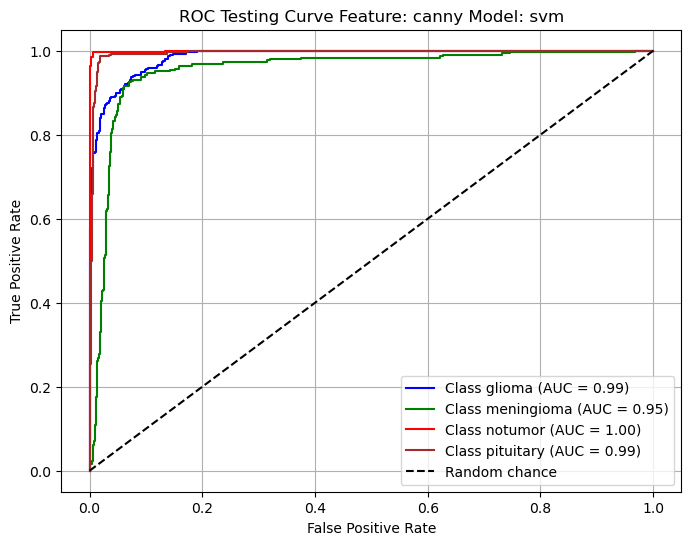

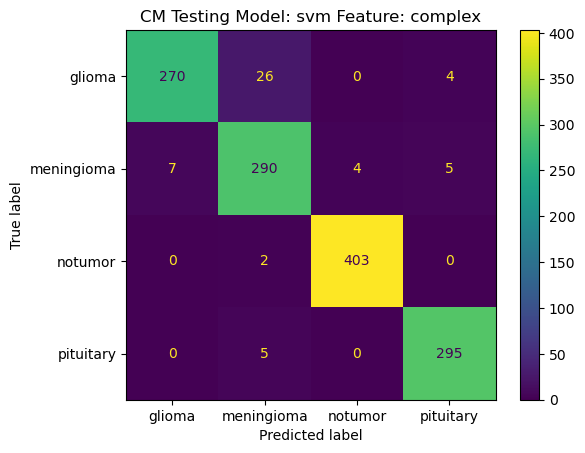

(1311, 4)


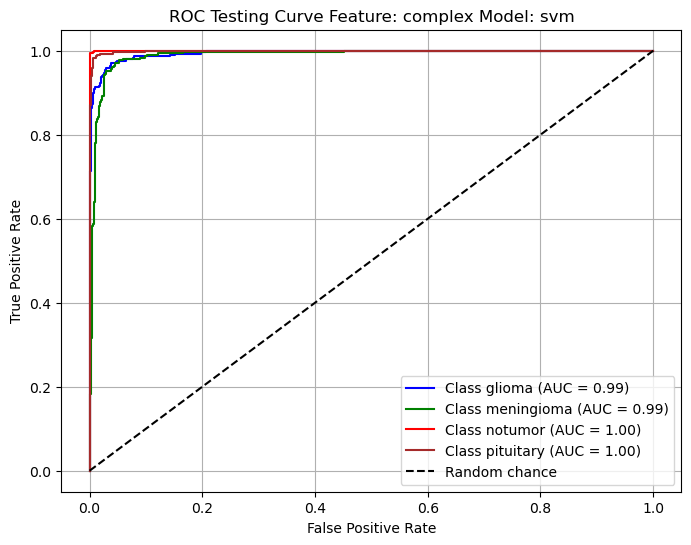

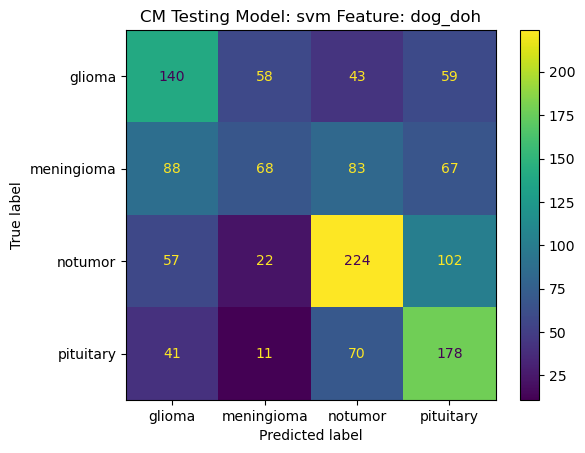

(1311, 4)


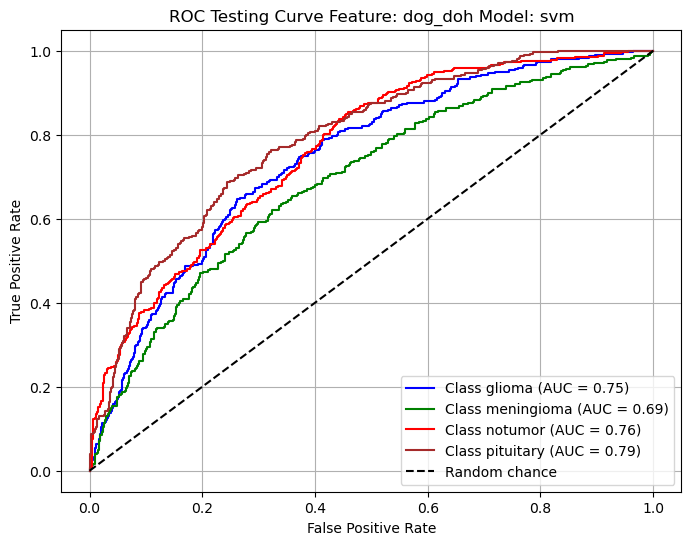

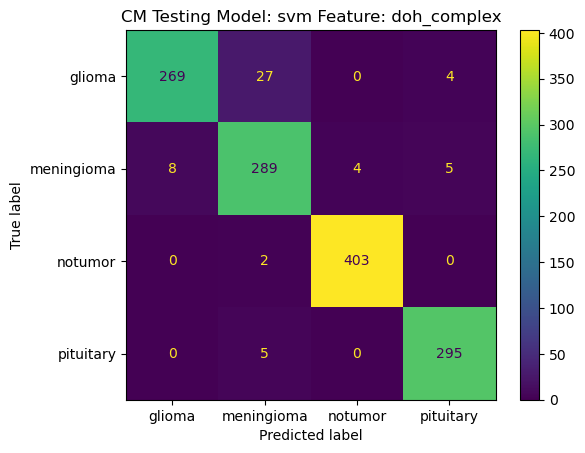

(1311, 4)


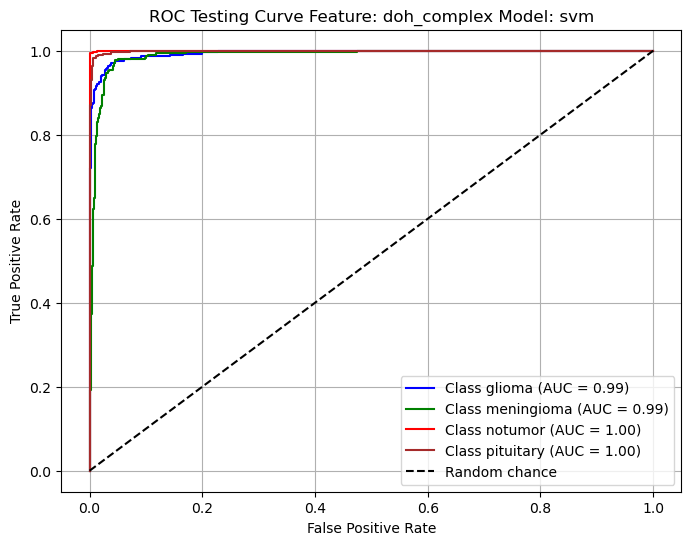

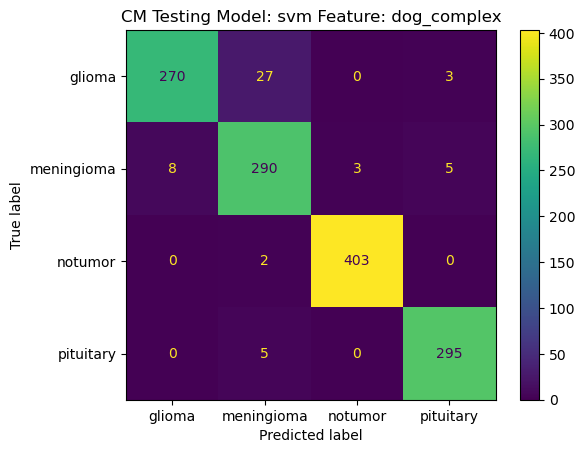

(1311, 4)


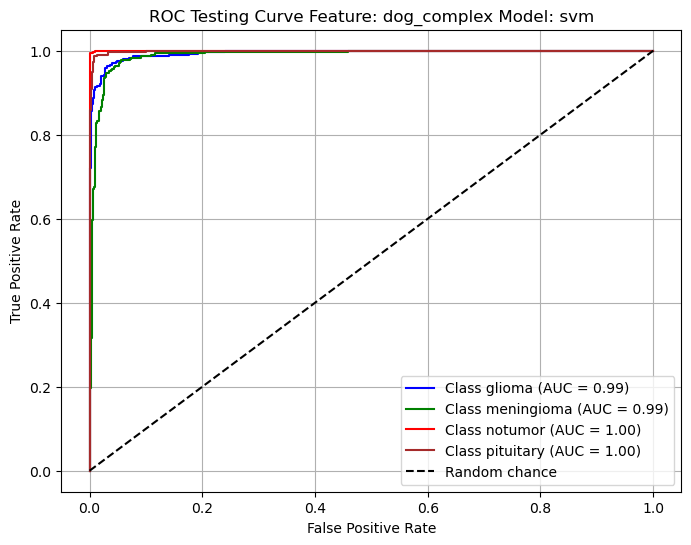

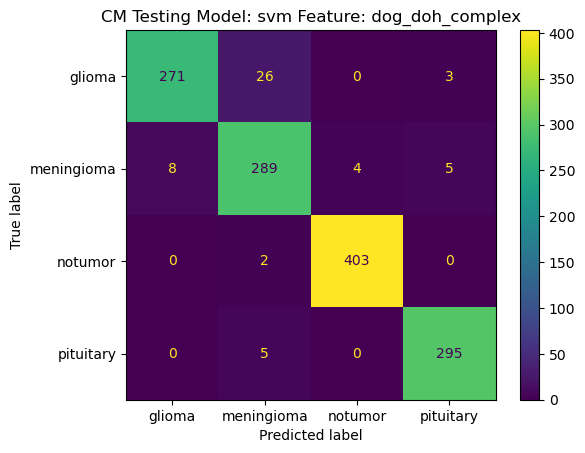

(1311, 4)


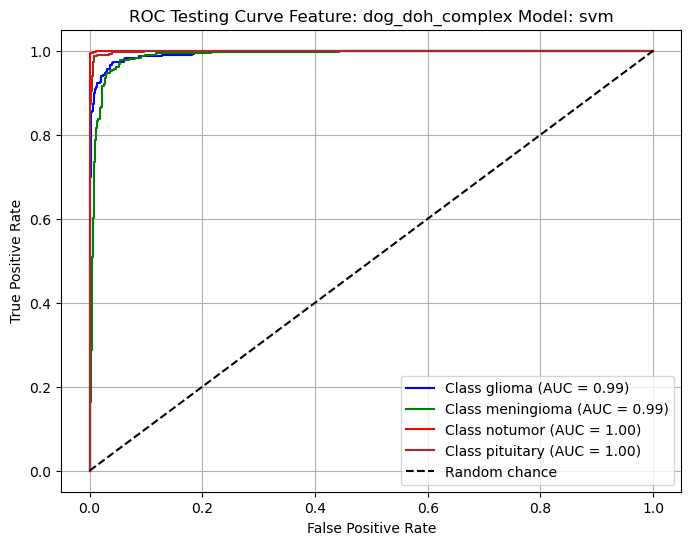

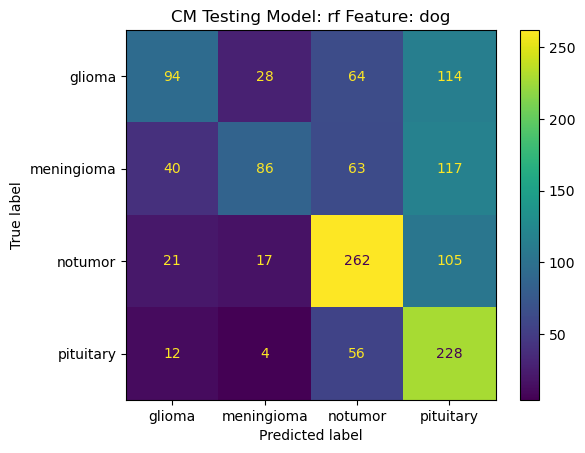

(1311, 4)


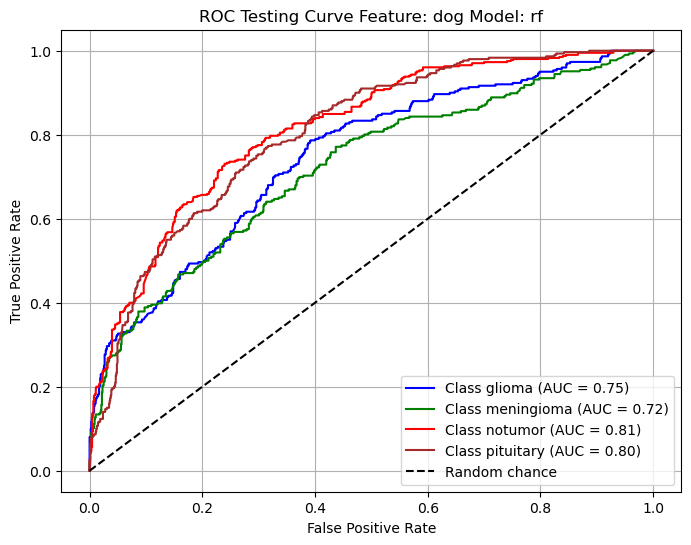

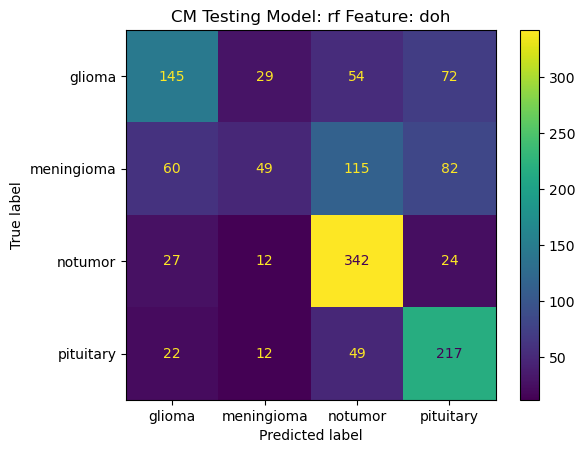

(1311, 4)


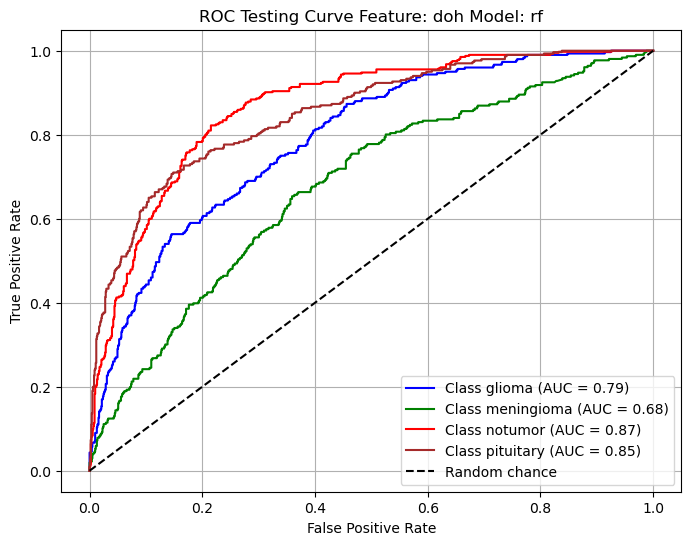

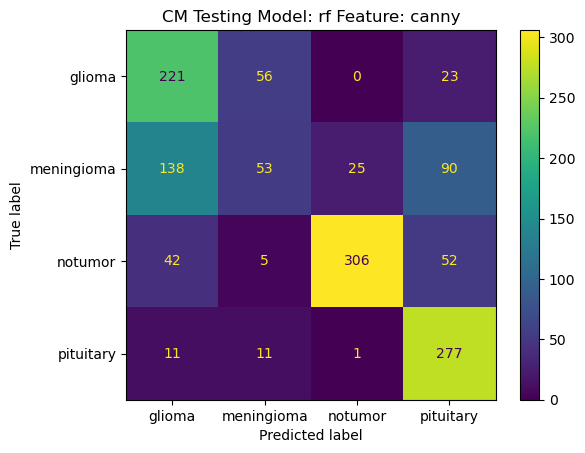

(1311, 4)


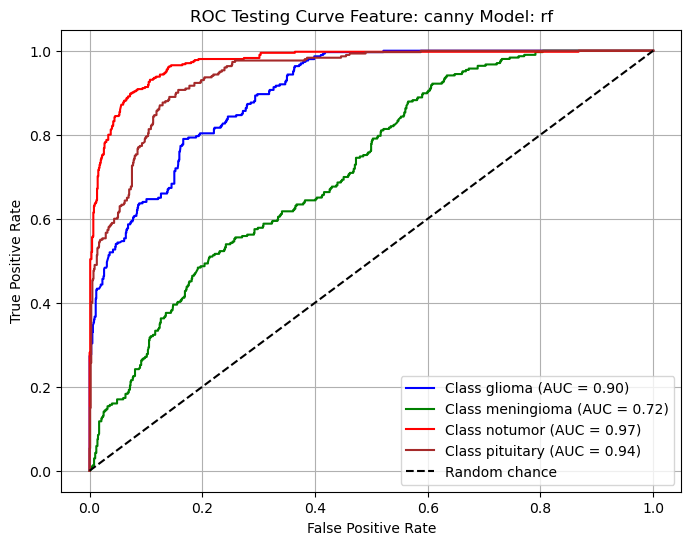

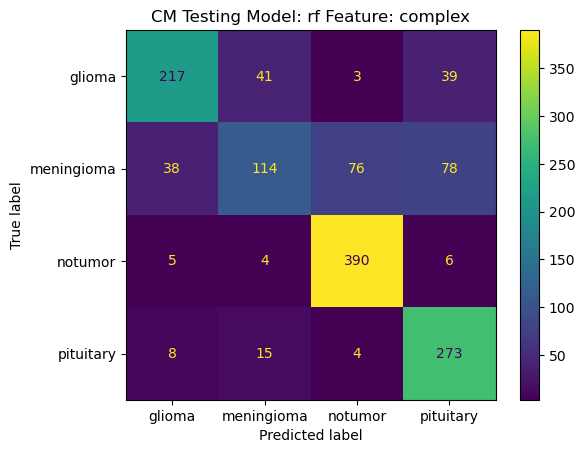

(1311, 4)


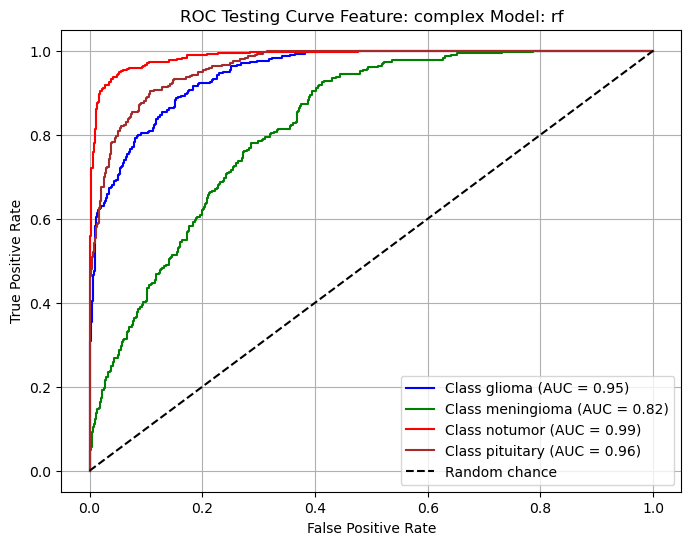

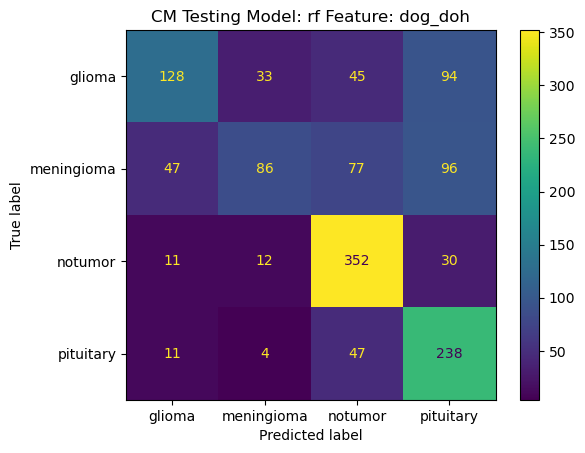

(1311, 4)


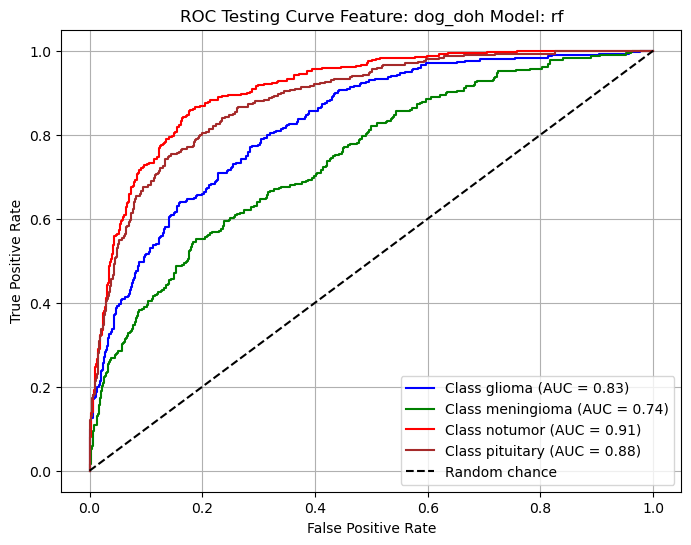

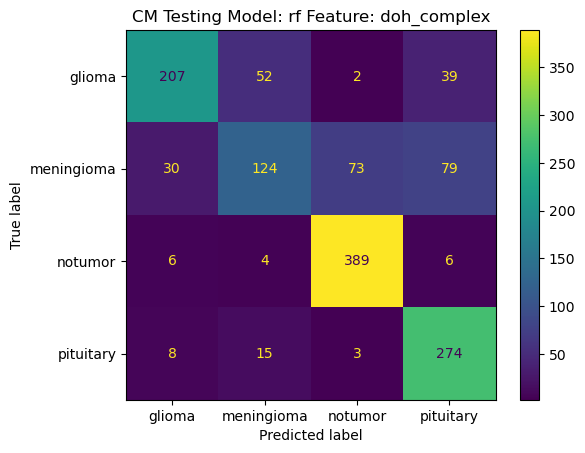

(1311, 4)


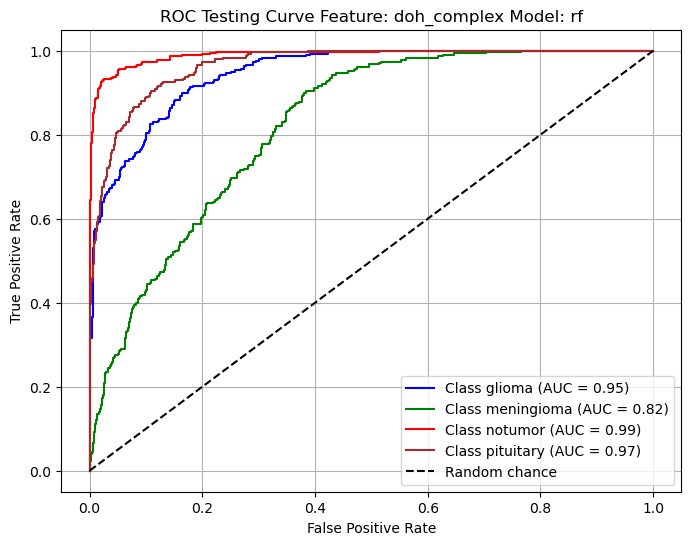

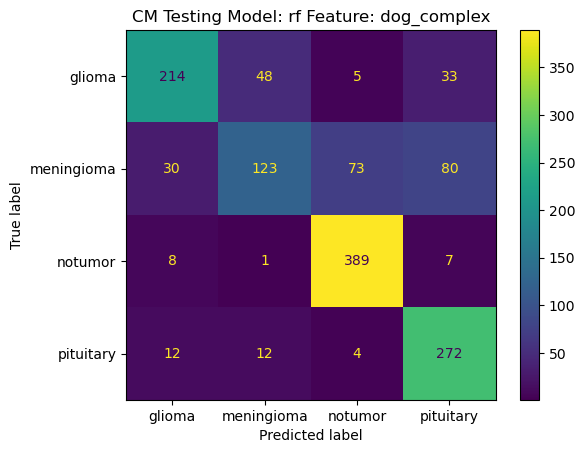

(1311, 4)


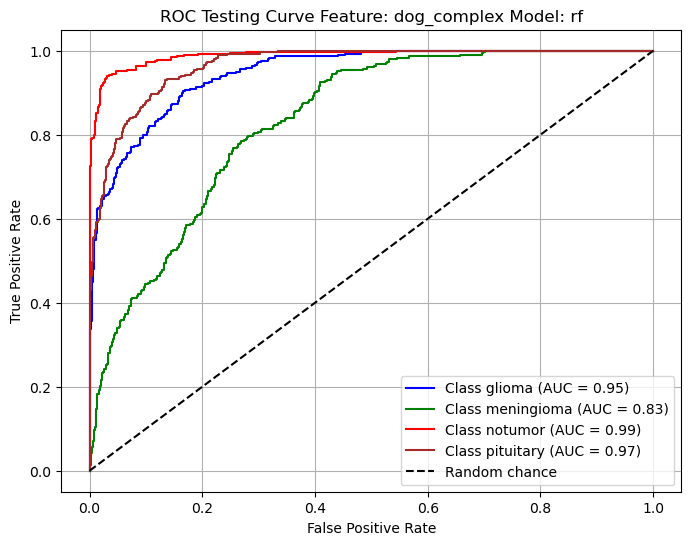

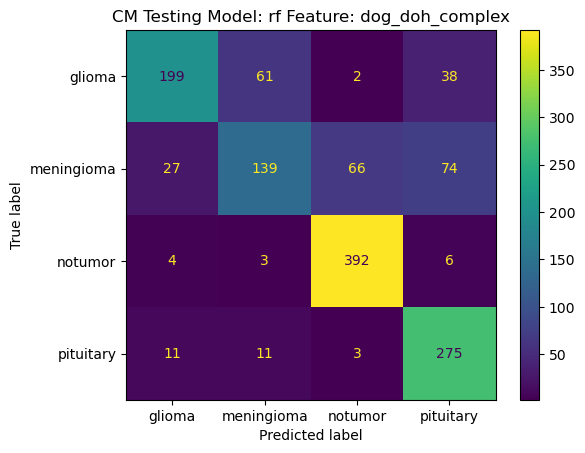

(1311, 4)


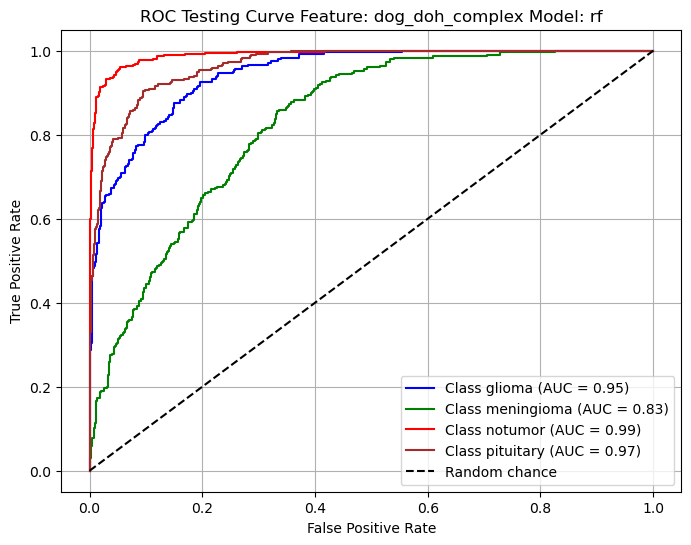

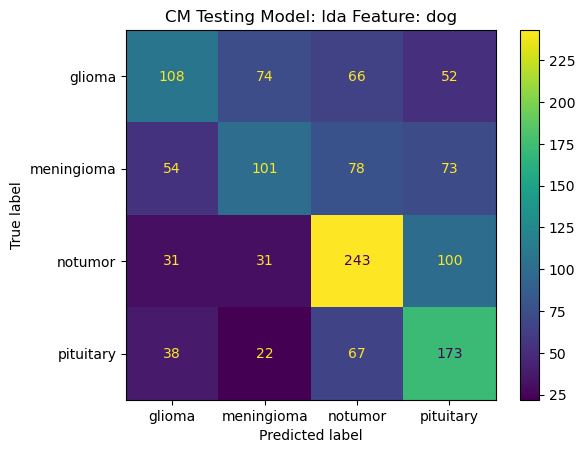

(1311, 4)


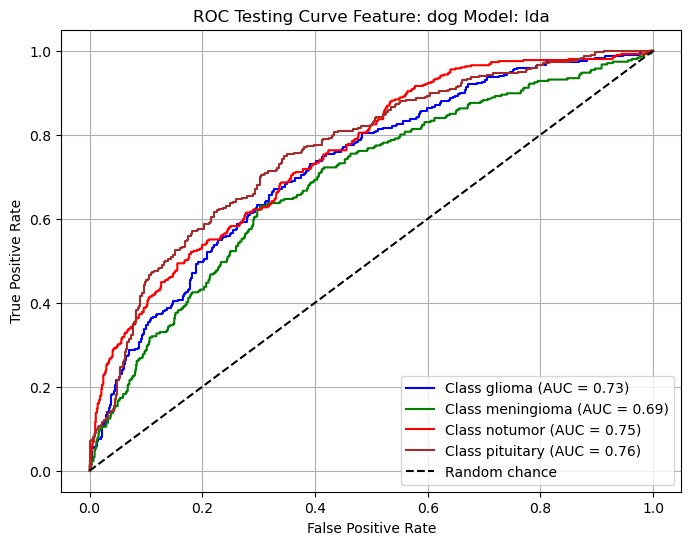

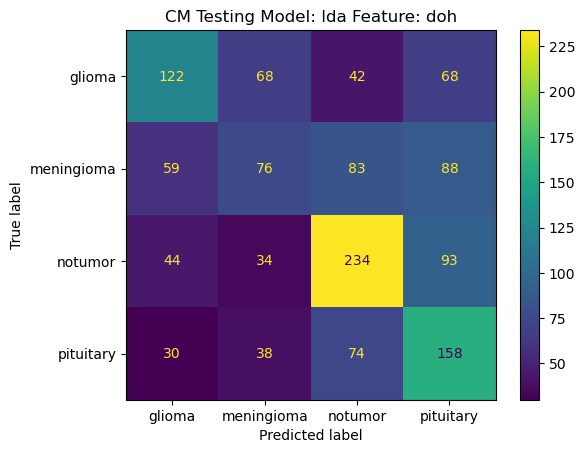

(1311, 4)


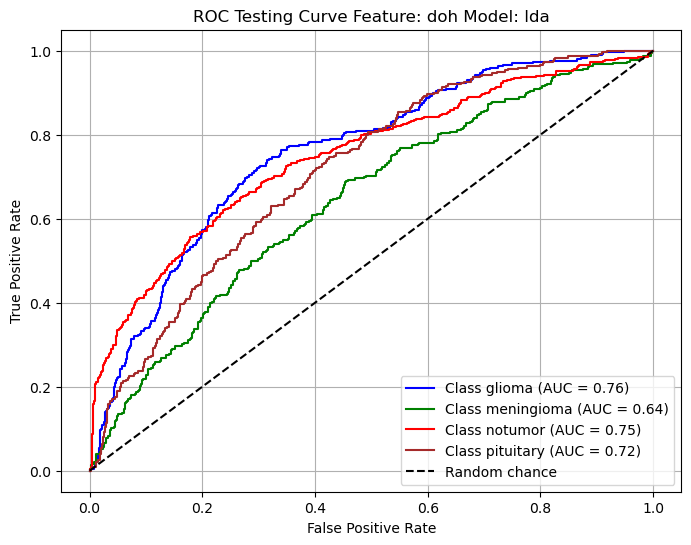

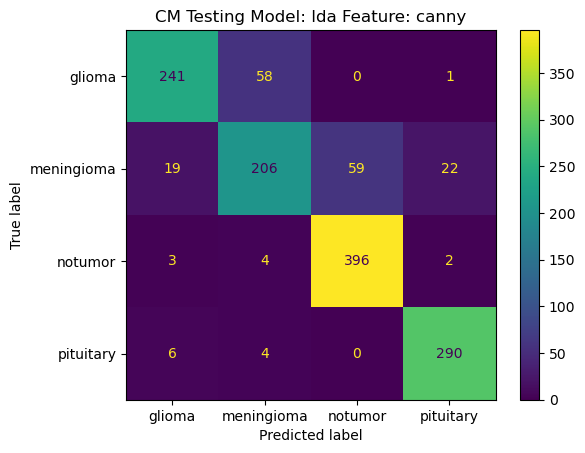

(1311, 4)


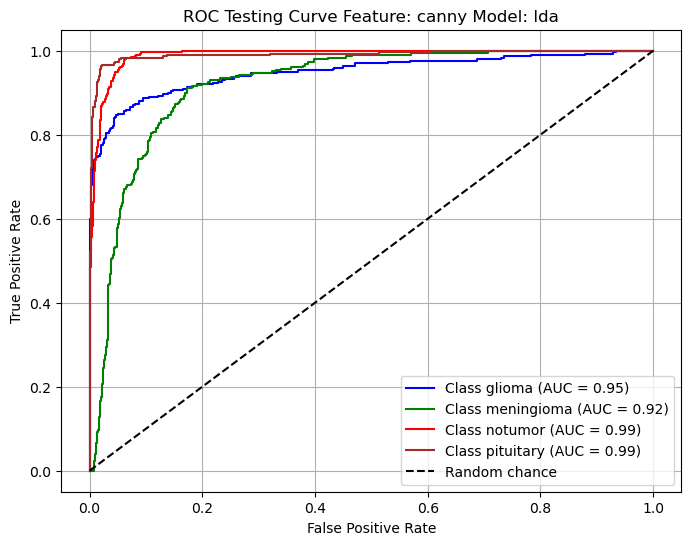

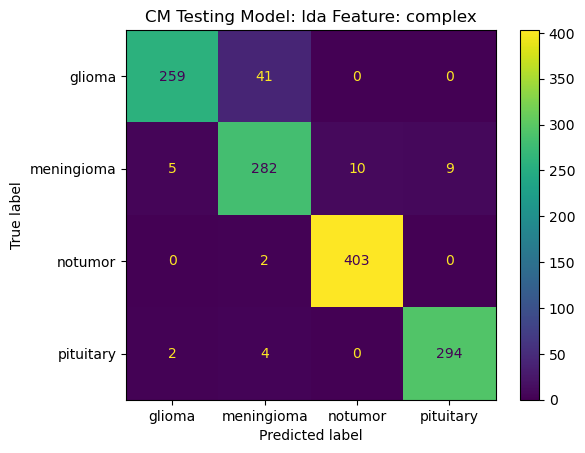

(1311, 4)


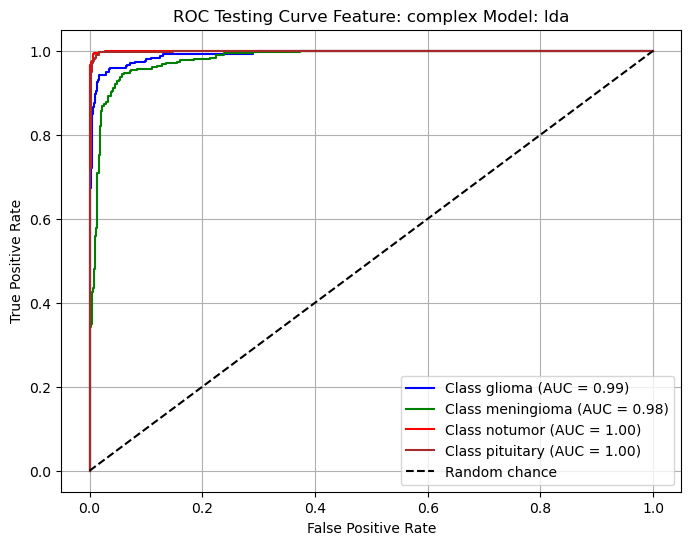

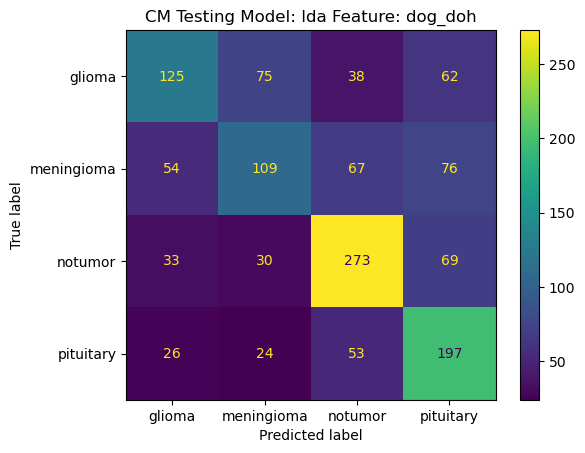

(1311, 4)


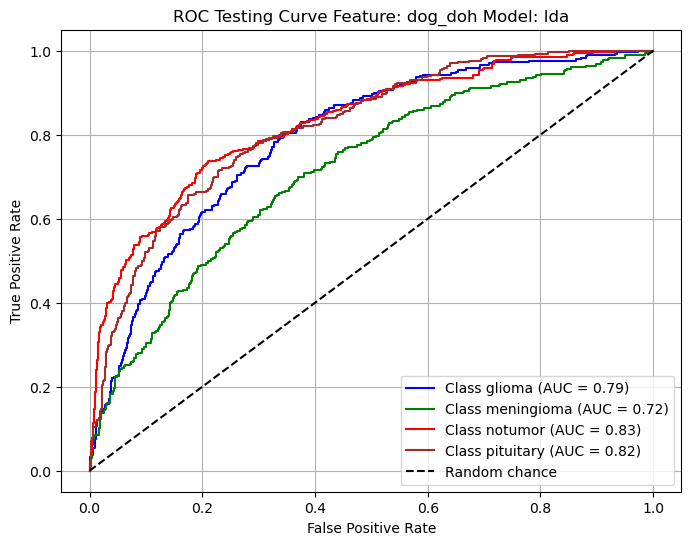

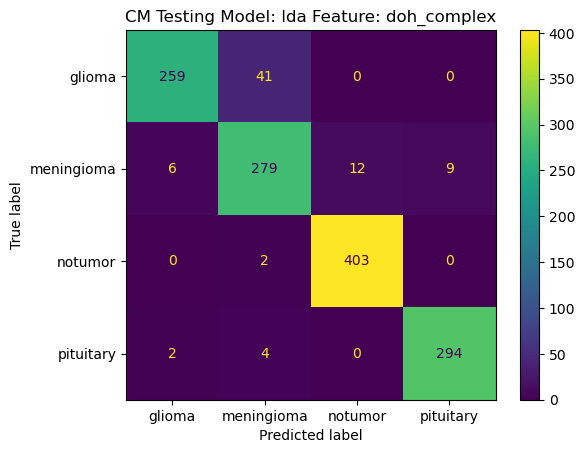

(1311, 4)


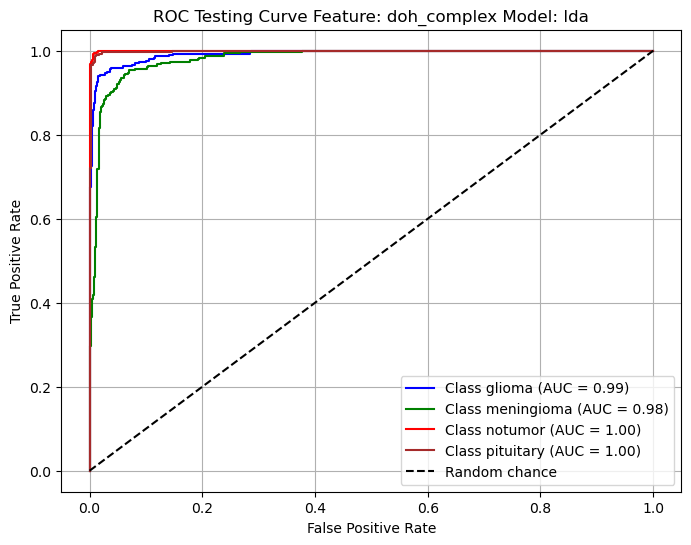

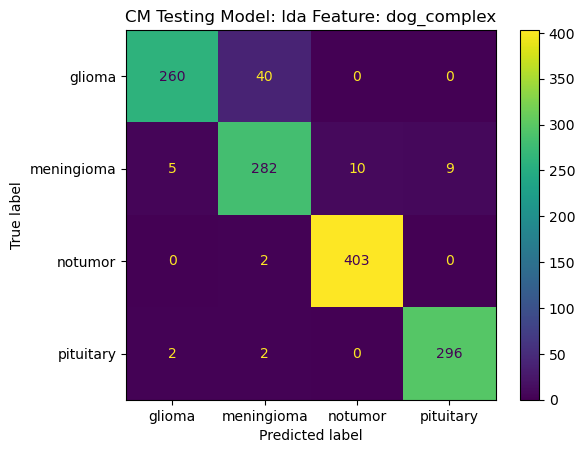

(1311, 4)


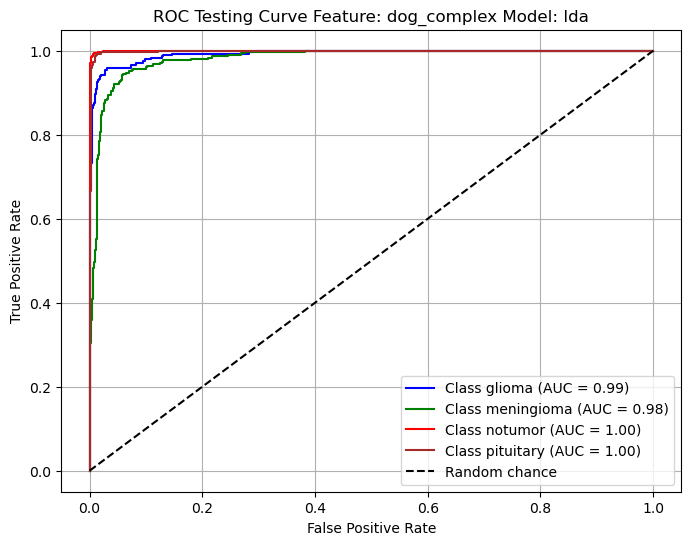

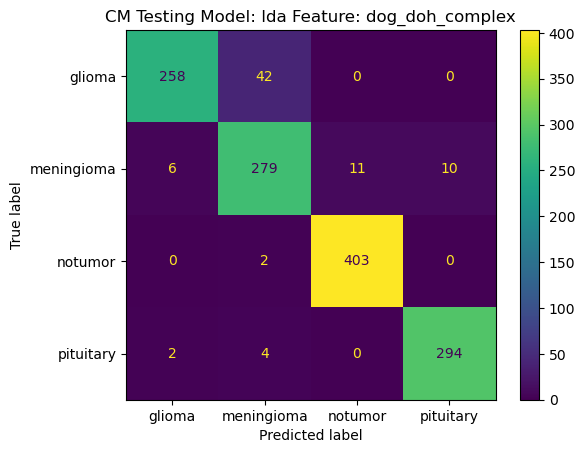

(1311, 4)


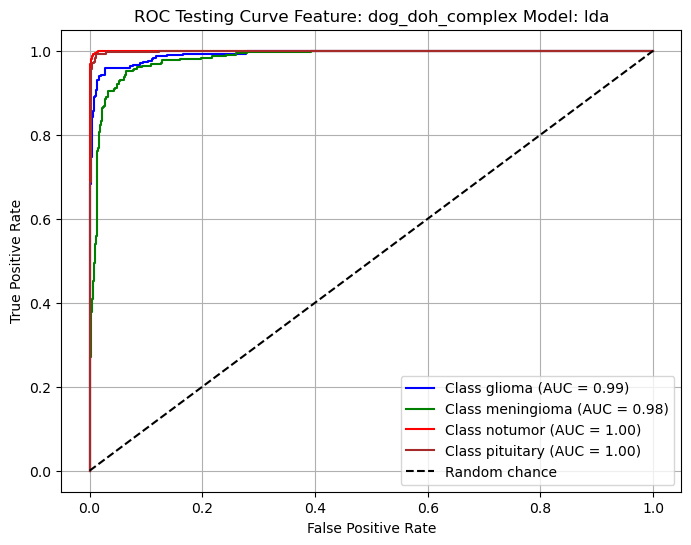

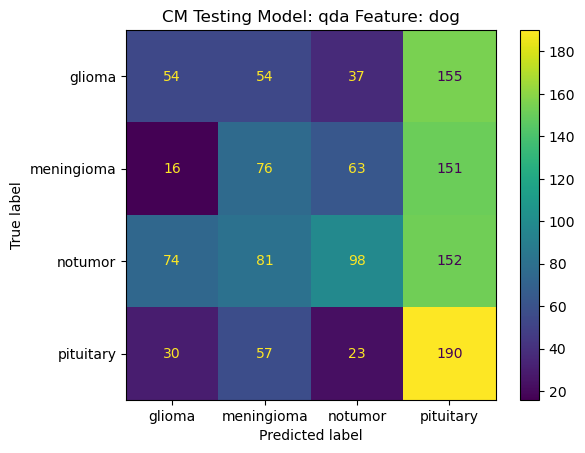

(1311, 4)


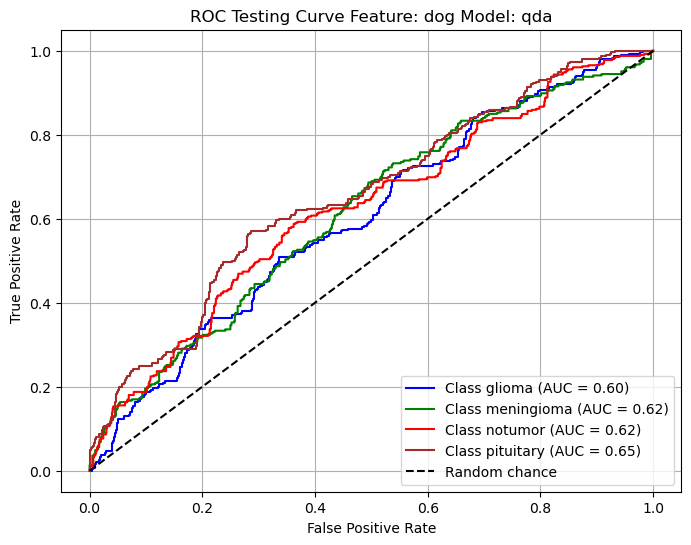

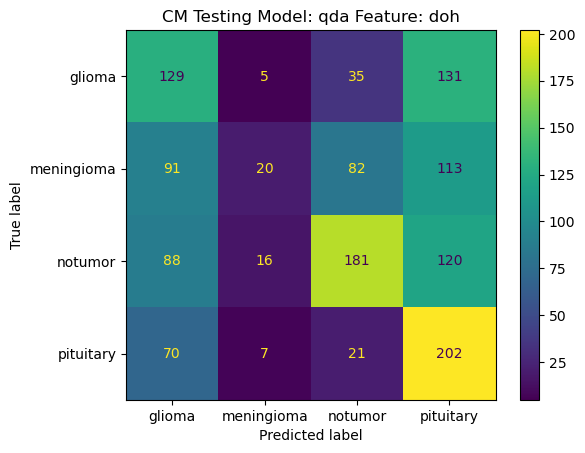

(1311, 4)


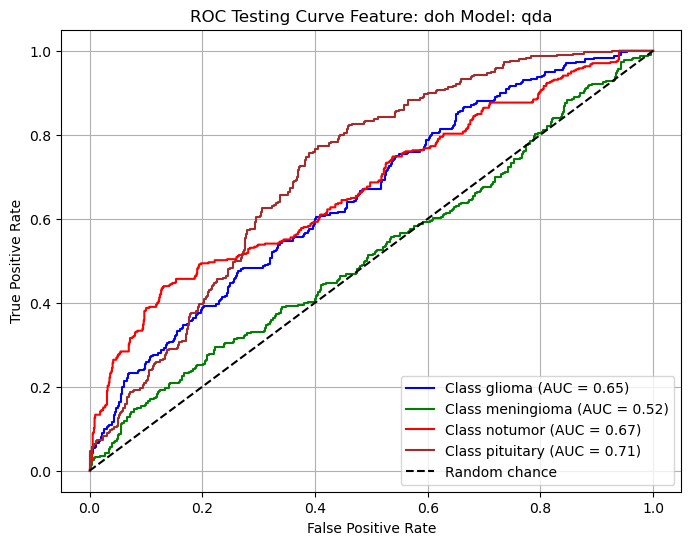

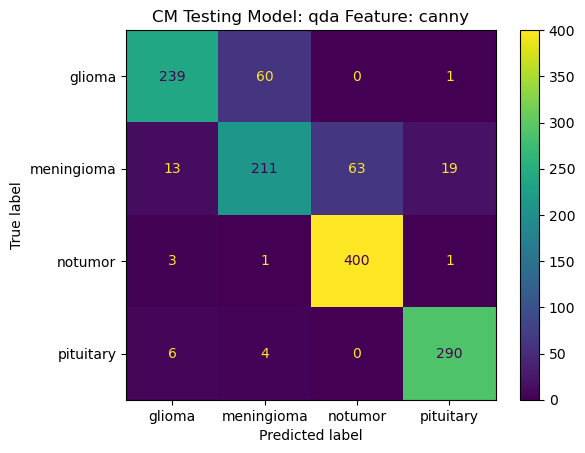

(1311, 4)


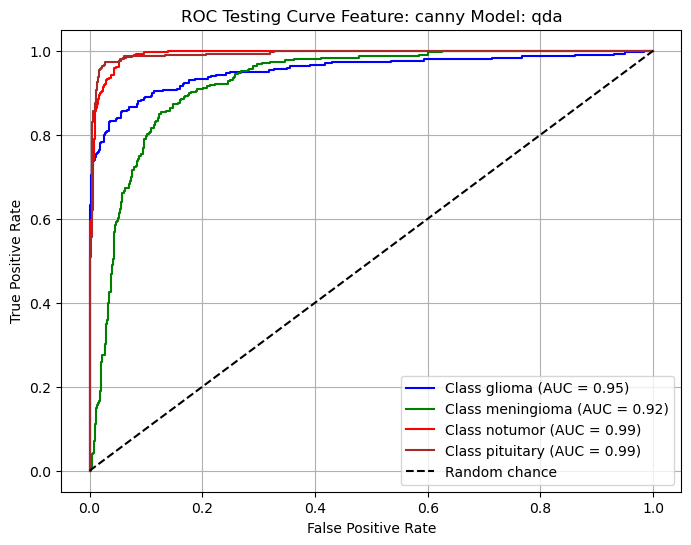

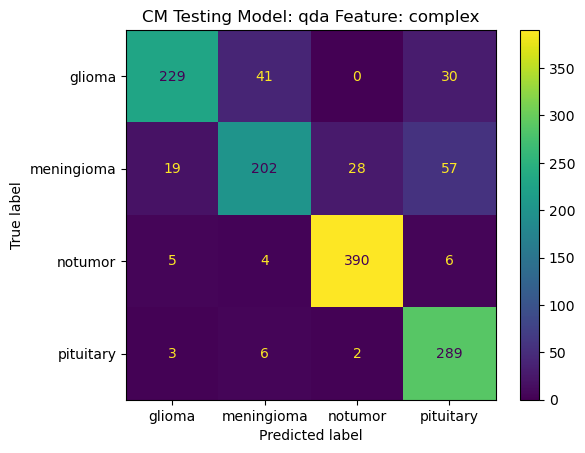

(1311, 4)


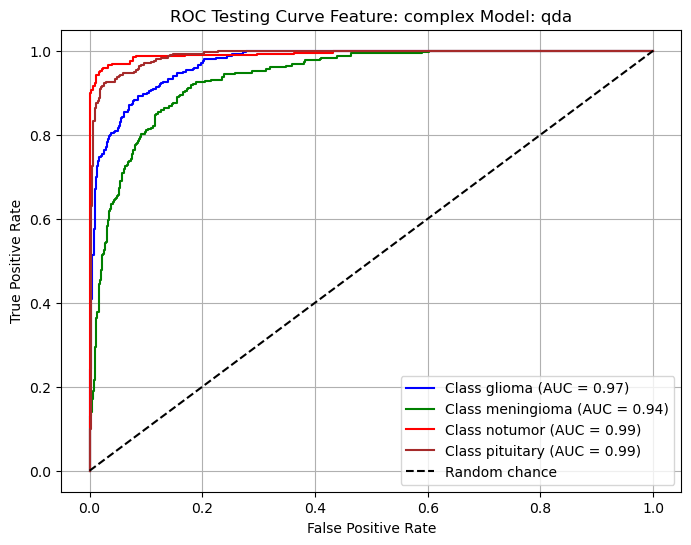

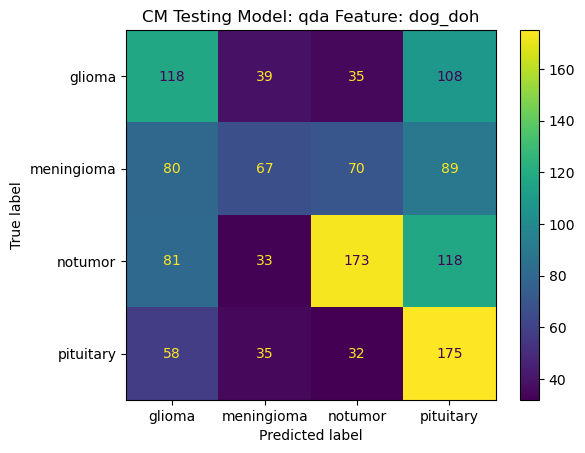

(1311, 4)


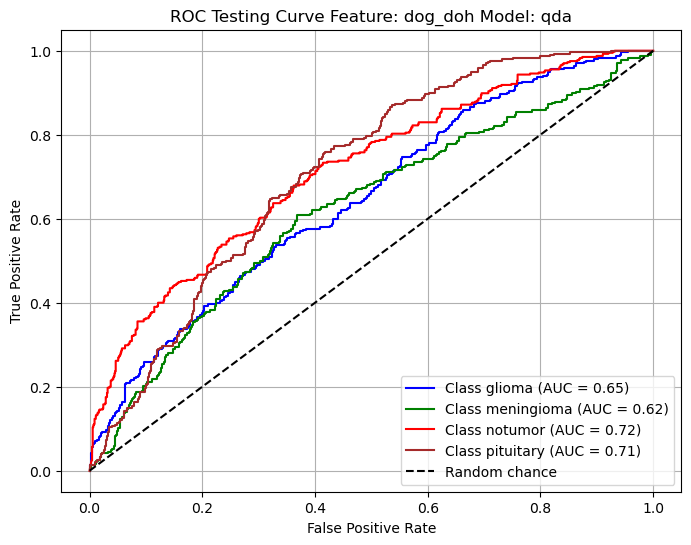

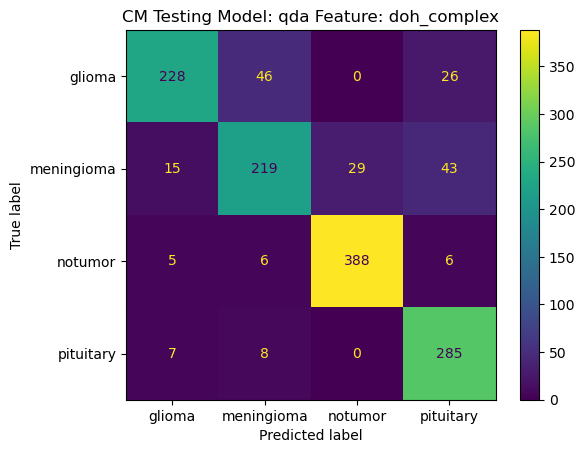

(1311, 4)


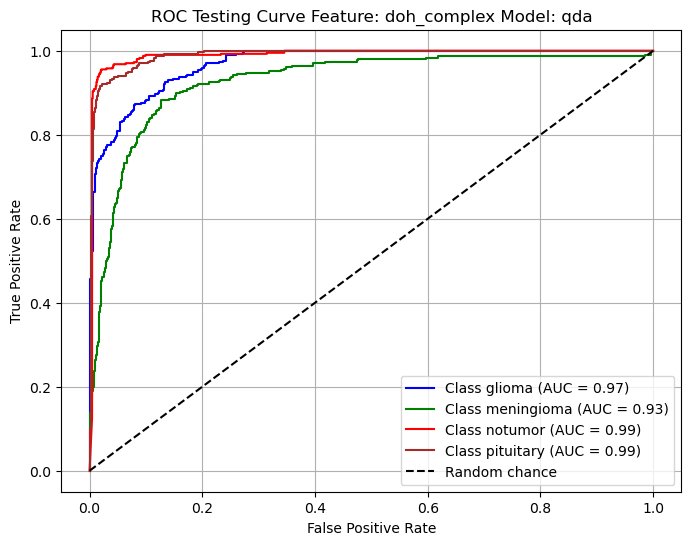

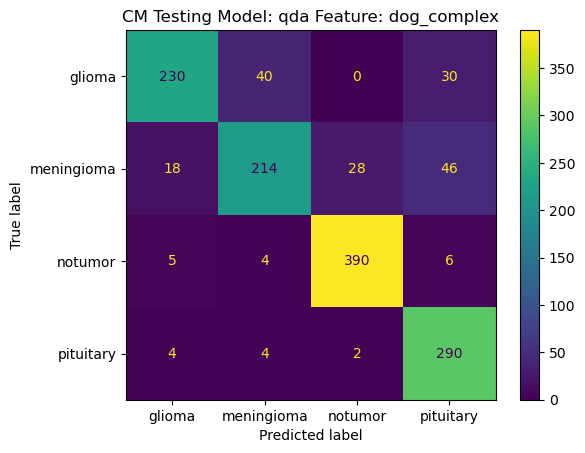

(1311, 4)


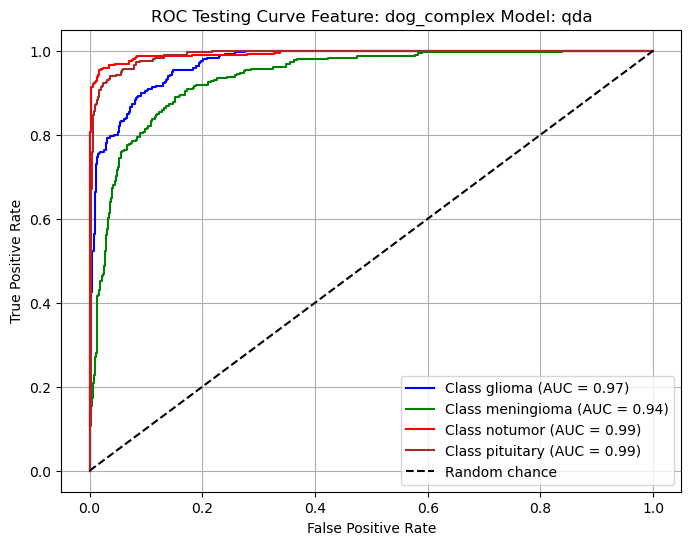

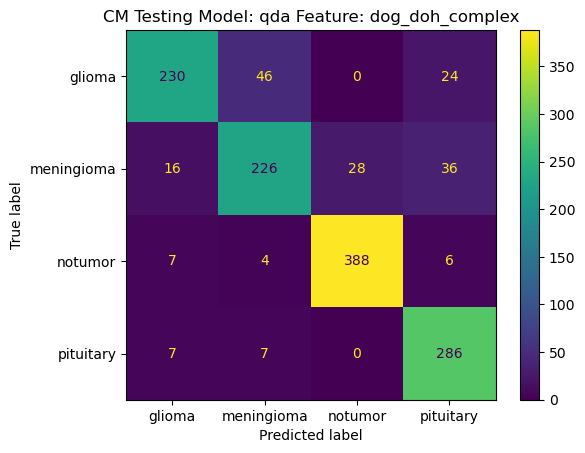

(1311, 4)


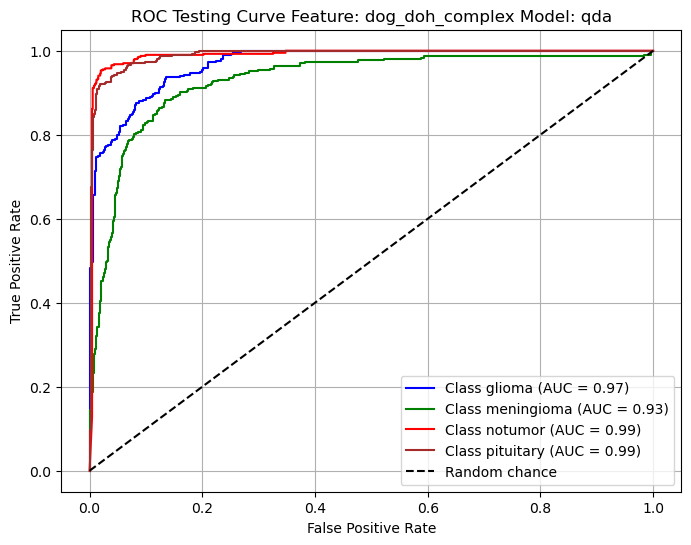

In [15]:
aligned_test_features = pd.read_csv('extracted_features/aligned_testing_features.csv')
aligned_test_features, dims, enc = clean_df(
    df=aligned_test_features,
    label_col="target",
    feat_cols=["feat_canny", "feat_vec", "feat_dog", "feat_doh"]
)

parsed_aligned_test_features  = parse_aligned_features(aligned_test_features, ['feat_canny', 'feat_vec', 'feat_dog', 'feat_doh'])

X_test_dog_features = parsed_aligned_test_features['feat_dog']
X_test_doh_features = parsed_aligned_test_features['feat_doh']
X_test_complex_features = parsed_aligned_test_features['feat_vec']
X_test_canny_features = np.load('extracted_features/X_test_canny.npy')
y_test = parsed_aligned_test_features['target']

features = {'dog':X_test_dog_features,
            'doh':X_test_doh_features,
            'canny':X_test_canny_features,
            'complex': X_test_complex_features,
            'dog_doh': np.concatenate((X_test_dog_features, X_test_doh_features), axis=1),
            'doh_complex': np.concatenate((X_test_doh_features, X_test_complex_features), axis=1),
            'dog_complex': np.concatenate((X_test_dog_features, X_test_complex_features), axis=1),
            'dog_doh_complex': np.concatenate((X_test_dog_features, X_test_doh_features, X_test_complex_features), axis=1)
            }

all_test_results= pd.DataFrame(columns = ['feature', 'model_type', 'accuracy_score', 'macro_precision', 'macro_recall', 'macro_f1', 
                                      'micro_precision', 'micro_recall', 'micro_f1', 'inference_time'])

for model in loaded_models.keys():
    feature = model.split('_',1)[-1]
    model_type = model.split('_',1)[0]
    
    X_test = features[feature]

    result_dict = test_model(loaded_models[model], X_test, y_test, le.classes_, model_type=str(model_type), feature=str(feature))
    all_test_results.loc[len(all_test_results)] = result_dict

all_test_results.to_csv("results/test_results.csv")


### 9. Ensemble Method Test

================== TESTING METRICS ===================
Accuracy Score: 0.9427917620137299
Macro Precision: 0.9392397111037245
Macro Recall: 0.9382552650689907
Macro F1: 0.9383347968823896
Micro Precision: 0.9427917620137299
Micro Recall: 0.9427917620137299
Micro F1: 0.9427917620137299


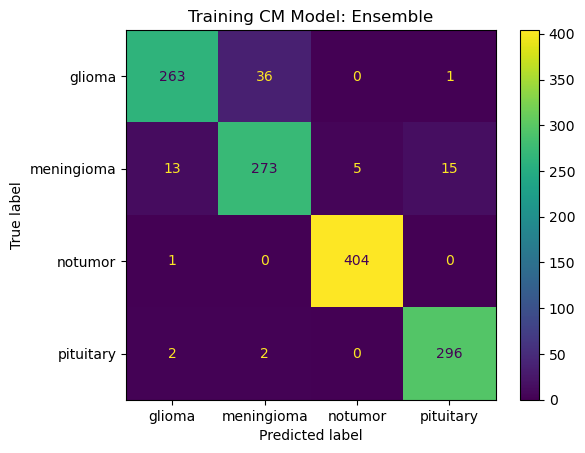

In [18]:
ensemble = FeatureVectorEnsemble(
    models=[loaded_models['logistic_canny'], loaded_models['svm_canny'], loaded_models['logistic_complex']],
    feature_sets=[X_test_canny_features, X_test_canny_features, X_test_complex_features],
    use_proba=True
)


y_ensemble_test_pred = []

for image in range(X_test_canny_features.shape[0]):
    prediction = ensemble.predict(image)
    y_ensemble_test_pred.append(prediction)

y_ensemble_test_pred = np.array(y_ensemble_test_pred)
accuracy_score = metrics.accuracy_score(y_test, y_ensemble_test_pred)
macro_precision = metrics.precision_score(y_test, y_ensemble_test_pred,average ='macro')
macro_recall = metrics.recall_score(y_test, y_ensemble_test_pred,average='macro')
macro_f1 = metrics.f1_score(y_test, y_ensemble_test_pred,average='macro')
micro_precision = metrics.precision_score(y_test, y_ensemble_test_pred,average='micro')
micro_recall = metrics.recall_score(y_test, y_ensemble_test_pred,average='micro')
micro_f1 = metrics.f1_score(y_test, y_ensemble_test_pred,average='micro')
# Generate Confusion Matrix for Logistic Regression
confusion_matrix = metrics.confusion_matrix(y_test, y_ensemble_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = le.classes_)
cm_display.plot()
plt.title('Training CM Model: Ensemble')

print("================== TESTING METRICS ===================")
print("Accuracy Score: " + str(accuracy_score))
print("Macro Precision: " + str(macro_precision))
print("Macro Recall: " + str(macro_recall))
print("Macro F1: " + str(macro_f1))
print("Micro Precision: " + str(micro_precision))
print("Micro Recall: " + str(micro_recall))
print("Micro F1: " + str(micro_f1))